In [10]:
cmap_name = 'jet'

loaded 1 existing images from dataset of size [16, 16]
loaded 1 existing weights from weights-minFalse-r1v2


/Users/garth/miniconda3/envs/ddn/lib/python3.8/site-packages/ipyplot/_utils.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(seq)



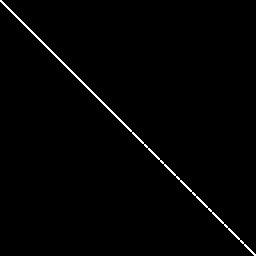


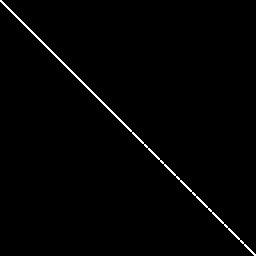

In [11]:
# THE DATA PORTION
# load a sample, see how it looks
import ipyplot

import sys
sys.path.append("../")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from net_argparser import net_argparser
from data import *

args = net_argparser(ipynb=True)
args.network = 1
args.total_images = 1
args.minify = False
args.radius = 1
args.img_size = [16,16] # the default is 32,32 anyway

train_dataset = SimpleDatasets(args, transform=transforms.ToTensor())
row = [train_dataset.get_image(0), train_dataset.get_segmentation(0), de_minW(train_dataset.get_weights(0))]




ipyplot.plot_images([a.numpy()[0] for a in row], ['input', 'segmentation', 'weights'], img_width=150)

In [12]:
# # old broken code to visualise
# # - eigh only takes 3d inputs, not 4d. Changing this fixes it

# out = train_dataset.get_weights(0)[:,None,:,:]
# B,C,r,N = out.shape
# if r != N:
#     reconst = torch.zeros((B,C,N,N), device=out.device)
#     diags = r + 1 # include the main diagonal of ones
#     for b in range(B):
#         for c in range(C):
#             for i  in range(0, diags):
#                 if i == 0: # add the main diagonal (of all ones)
#                     reconst[b][c] = torch.add(reconst[b][c], torch.eye(N, device=out.device))
#                 else: # add the symmetric non-main diagonals
#                     diagonal = out[b][c][i-1]
#                     temp = torch.diag(diagonal[:N-i], i).to(out.device) # [:N-i] trims to fit the index'th diag size, places into index'th place
#                     reconst[b][c] = torch.add(reconst[b][c], temp) # add the upper diagonal (or middle if 0)
#                     temp = torch.diag(diagonal[:N-i], -i).to(out.device)
#                     reconst[b][c] = torch.add(reconst[b][c], temp) # add the lower diagonal (symmetric)

# A = reconst
# b,c,x,y = A.shape
# out_size = int(np.sqrt(x)) # NOTE: assumes it is square..

# # can also replace bc with ...
# d = torch.einsum('bcij->bcj', A) # eqv to A.sum(0) --- d vector
# D = torch.diag_embed(d) # D = matrix with d on diagonal
# D_inv_sqrt = torch.diag_embed(d.pow(-0.5)) # Don't calculate inverse sqrt of 0 entries (non diagonals)

# L = (D-A) # Laplacian matrix
# # The symmetrically normalized laplacian can be calculated as D^-0.5 * L * D^-0.5 or eqv. I - D^-0.5 * A * D^-0.5 
# L_norm = torch.einsum('bcij,bcjk->bcik', torch.einsum('bcij,bcjk->bcik', D_inv_sqrt , L) , D_inv_sqrt)
# L_norm = L_norm.to(A.device) # TODO : more elegant fix?

# # Solve eigenvectors and eigenvalues
# (w, v) = torch.linalg.eigh(L_norm)

# # Returns the second smallest eigenvector (and possibly more if num_eigs > 1)
# # eigenvector(s) reshaped to match original image size
# num_eigs = 1
# # TODO: verify if the eig is the correct one... (narrowed to index 1 not index 0, but possible it already removes this one)

# # Detach inputs from graph, attach only the output (or if using optimisation to solve you can with torch.enable_grad() ( ... optim ))
# output = v.narrow(-2, 1, num_eigs).squeeze(1).reshape(b, num_eigs, out_size, out_size)
# plot_multiple_images(0, [train_dataset.get_segmentation(0), output, de_minW(train_dataset.get_weights(0))], figsize=args.img_size, ipynb=True, cmap_name=cmap_name)


In [13]:
from scipy import linalg
# test slowly verifying the einsums

A = train_dataset.get_weights(0)
A_smol = train_dataset.get_weights(0).squeeze()
print(f'shapes\npre A {A.shape}, {A_smol.shape}')
A = de_minW(train_dataset.get_weights(0))
A_smol = de_minW(train_dataset.get_weights(0)).squeeze()
print(f'post A {A.shape}, {A_smol.shape}')
assert torch.allclose(A.squeeze(), A_smol)

# added for later changes
A_smol = A_smol.type(torch.double)
A = A.type(torch.double)

d = torch.einsum('bij->bj', A)
d_smol = A_smol.sum(0)
print(f'd {d.shape}, {d_smol.shape}')
assert torch.allclose(d.squeeze(), d_smol), "degree matrix error"

D = torch.diag_embed(d)
D_smol = torch.diag(d_smol)
print(f'D {D.shape}, {D_smol.shape}')
assert torch.allclose(D.squeeze(), D_smol), "diagonalising error"

D_inv_sqrt = torch.diag_embed(d).pow(-0.5) # was previously in the diag_embed, avoided inf values, but made it so they were different
D_inv_sqrt_2 = torch.diag_embed(d.pow(-0.5)) # NOTE: this is the same as using torch.mm(torch.diag(...)) with the reverse of these...
D_smol_inv_sqrt = torch.pow(torch.diag(d_smol),-0.5)
print(f'inv sqrt {D_inv_sqrt.shape}, {D_smol_inv_sqrt.shape}')
assert torch.allclose(D_inv_sqrt.squeeze(), D_smol_inv_sqrt) ,"inverse sqrt error"

L = D-A
L_smol = D_smol - A_smol
print(f'L {L.shape}, {L_smol.shape}')
# NOTE: requires matching sizes for D and A (so not minified A)
assert torch.allclose(L.squeeze(), L_smol) ,"laplacian error"

Lsym_smol = torch.mm(torch.mm(torch.diag(torch.pow(torch.diag(D_smol),-0.5)),L_smol),torch.diag(torch.pow(torch.diag(D_smol),-0.5)))

Lsym = torch.einsum('...ij,...jk->...ik', torch.einsum('...ij,...jk->...ik', D_inv_sqrt_2 , L) , D_inv_sqrt_2)
print(f'Lsym {Lsym.shape}, {Lsym_smol.shape}')
assert torch.allclose(Lsym.squeeze(), Lsym_smol) ,"Lsym error"

expected_y = train_dataset.get_segmentation(0)
channels,height,width = expected_y.shape
batchs = 1
output_size = (height, width)

# NC STYLE - needs to be fixed
(w,v) = linalg.eig(L[0])
(w1,v1) = linalg.eig(Lsym[0])

# brute force testing :)
# view to convert into the correct shape, None to not lose dimension and maintain overall shape structure b,c,x,y
eigs = {
    'eig_1_None' : np.real(v[:,1,None]).reshape(output_size),
    'eig_None_1' : np.real(v[:,None,1]).reshape(output_size),
    'eig_0_None' : np.real(v[:,0,None]).reshape(output_size),
    "eig_None_0" : np.real(v[:,None,0]).reshape(output_size),
    'eigSym_1_None' : np.real(v1[:,1,None]).reshape(output_size),
    'eigSym_None_1' : np.real(v1[:,None,1]).reshape(output_size),
    'eigSym_0_None' : np.real(v1[:,0,None]).reshape(output_size),
    "eigSym_None_0" : np.real(v1[:,None,0]).reshape(output_size),
}

def f(a):
    if a[0][0] > 0.5:
            a = 1 - a
    return a

eigs = {k: f(v) for k, v in eigs.items()}


ipyplot.plot_images(list(eigs.values()), list(eigs.keys()), img_width=150)

batch_y1 = np.real(v[:,1,None]).reshape(output_size) # second smallest eigenvector from eig
batch_y0 = np.real(v[:,0,None]).reshape(output_size) # smallest from eig
print(f'batch_y1 - Max: {np.max(batch_y1):.4f}, Min: {np.min(batch_y1):.4f}, Mean: {np.mean(batch_y1):.4f}, Median: {np.median(batch_y1):.4f}, std var: {np.std(batch_y1):.4f}')
print(f'batch_y0 - Max: {np.max(batch_y0):.4f}, Min: {np.min(batch_y0):.4f}, Mean: {np.mean(batch_y0):.4f}, Median: {np.median(batch_y0):.4f}, std var: {np.std(batch_y0):.4f}')


shapes
pre A torch.Size([1, 256, 256]), torch.Size([256, 256])
post A torch.Size([1, 256, 256]), torch.Size([256, 256])
d torch.Size([1, 256]), torch.Size([256])
D torch.Size([1, 256, 256]), torch.Size([256, 256])
inv sqrt torch.Size([1, 256, 256]), torch.Size([256, 256])
L torch.Size([1, 256, 256]), torch.Size([256, 256])
Lsym torch.Size([1, 256, 256]), torch.Size([256, 256])


batch_y1 - Max: 0.1231, Min: -0.1231, Mean: -0.0000, Median: 0.0000, std var: 0.0625
batch_y0 - Max: 0.0870, Min: 0.0000, Mean: 0.0449, Median: 0.0870, std var: 0.0435


output:torch.Size([1, 1, 16, 16]), expected:torch.Size([1, 16, 16]), weights:torch.Size([1, 256, 256])


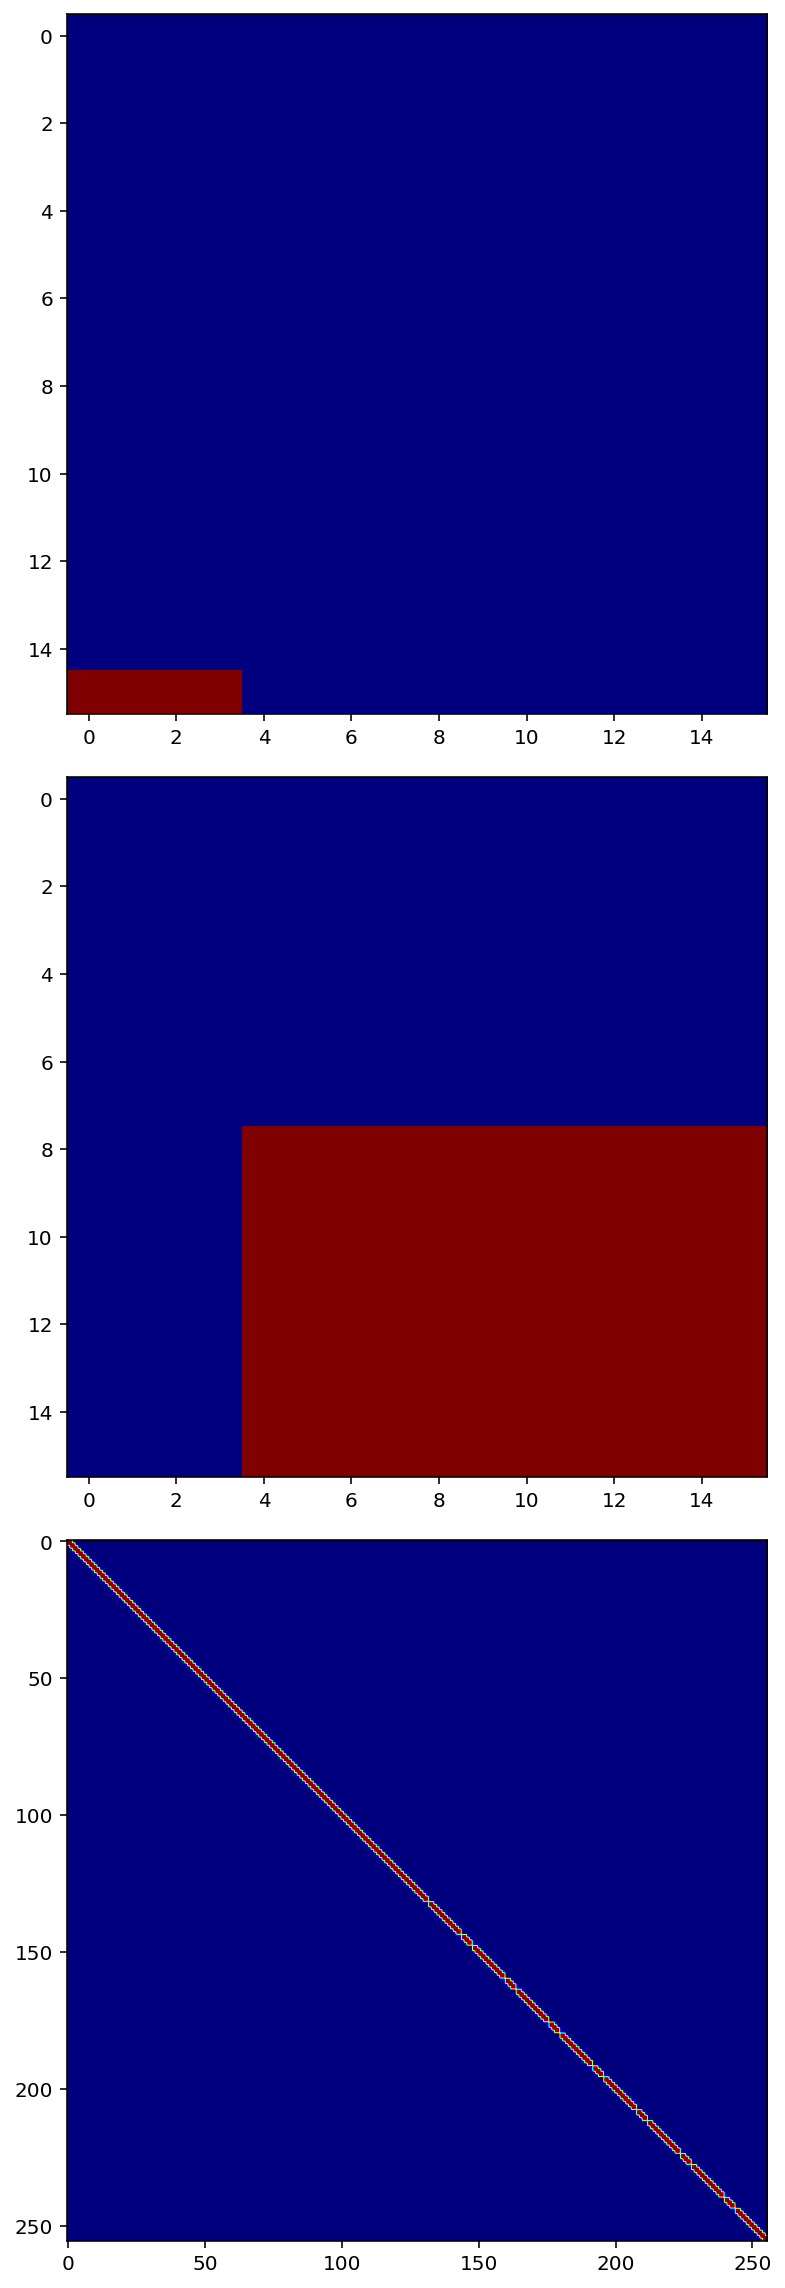

In [14]:
# The nc.py portion
# using the loaded data, see how it is segmented

# TODO: change to 0 not 1 for nc.py eigenvector
# TODO: fix objective function not being 0!
# TODO: fix equality constraint

from nc import NormalizedCuts
from node import DeclarativeLayer

nc = NormalizedCuts(eps=1) # check if eps value is correct, also test gamma for gradients..
decl = DeclarativeLayer(nc)

x = row[2] # gets the full rank matrix
y = decl(x) # as in model.py
y = y.view(y.size(0), 1, args.img_size[0], args.img_size[1]) # convert from NC node into this

plot_images = [y, row[1], x] # x,y, expected y (the 2nd index must always be the weights (expects one less dim))
print(f'output:{y.shape}, expected:{row[1].shape}, weights:{x.shape}')


plot_multiple_images(0, plot_images, figsize=args.img_size, ipynb=True, cmap_name=cmap_name)

In [15]:
from nc import NormalizedCuts
from node import DeclarativeLayer

node = NormalizedCuts(eps=1e-3)
DL = DeclarativeLayer(node)


W = A
W = W.type(torch.double)

print(eigs.keys())

plots = []
labels = []
for name, y in eigs.items():
    print(f'y shape {y.shape}, W shape {W.shape}')
    print(name)
    f = node.objective(W, y)
    eq = node.equality_constraints(W,y)
    plots.append(y)
    labels.append(f'{f.item():.5f}\n{eq.item():.5f}\n{name}')

plot_multiple_images(0, plots, figsize=args.img_size, ipynb=True, cmap_name=cmap_name, labels=labels)



dict_keys(['eig_1_None', 'eig_None_1', 'eig_0_None', 'eig_None_0', 'eigSym_1_None', 'eigSym_None_1', 'eigSym_0_None', 'eigSym_None_0'])
y shape (16, 16), W shape torch.Size([1, 256, 256])
eig_1_None


TypeError: order must be str, not int